<a href="https://colab.research.google.com/github/hamza-dev-12/EmotionClassifer/blob/main/Emotion_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dependencies**

In [1]:
%%capture
!pip install datasets
!pip install transformers
!pip install pytorch-lightning

**Importing Libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

**Loading DataSet**

In [3]:
dataset = load_dataset('xed_en_fi','en_annotated')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/17528 [00:00<?, ? examples/s]

In [6]:
data = pd.DataFrame(dataset['train'])
data.head(5)

,sentence,labels
0,", ...",[1]
1,!,"[1, 4, 7]"
2,... And I don't think we need to discuss the T...,"[8, 1]"
3,* So get up out of your bed,[1]
4,A confession that you hired [PERSON] ... and a...,"[1, 6]"


In [7]:
attributes = [ 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

**Length of Sentences**

[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 170, 174, 176, 177, 179, 182, 183, 184, 185, 188, 192, 193, 194, 196, 198, 202, 204, 207, 209, 216, 218, 221, 222, 228, 229, 251, 261, 281, 290, 299]


<BarContainer object of 193 artists>

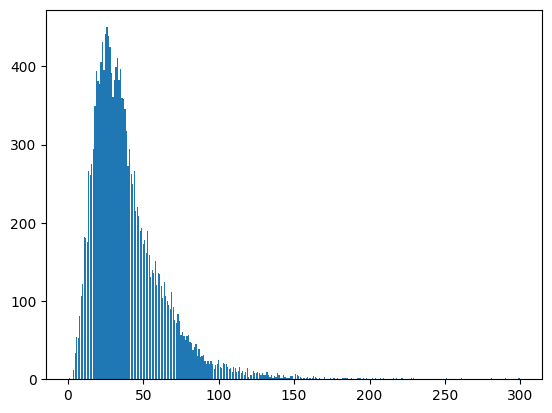

In [8]:
sentences_length = [len(sentence) for sentence in data['sentence']]
lens = list(set(sentences_length))
print(lens)
sen_count = pd.Series(sentences_length).value_counts().sort_index()
plt.bar(lens,sen_count.values)

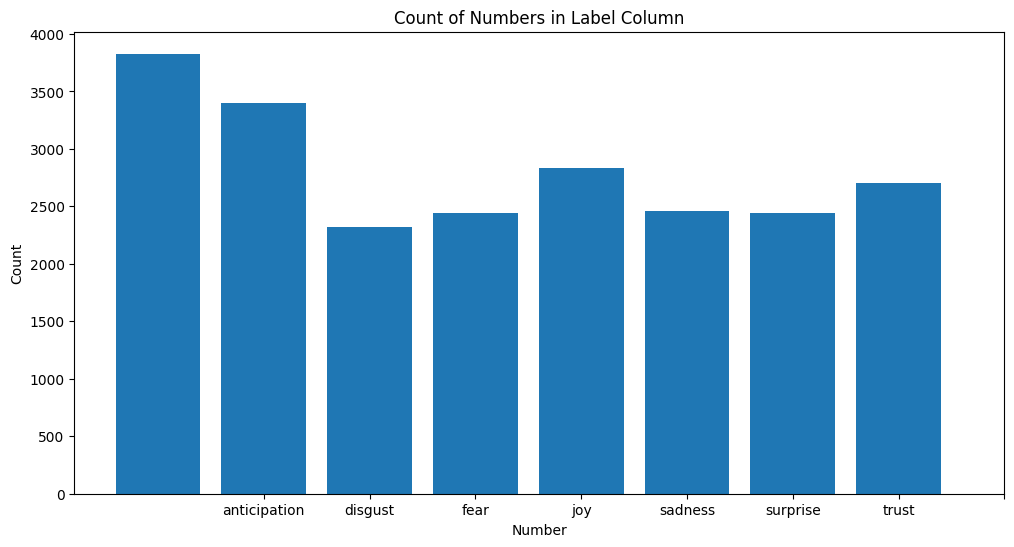

In [9]:
# Flatten the list of lists in the 'label' column
labels_flat = [item for sublist in data['labels'] for item in sublist]

# Count the occurrences of each number
label_counts = pd.Series(labels_flat).value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(attributes, label_counts.values)
plt.xlabel('Number')
plt.ylabel('Count')
plt.title('Count of Numbers in Label Column')
plt.xticks(range(1,9))  # Assuming the range is 1-8
plt.show()

In [10]:
data['sentence'][0]


', ...'

In [11]:
class Em_Dataset(Dataset):
  def __init__(self,dataset_name,dataset_config,tokenizer,attributes,max_token_len : int = 128,sample = 6000,split = 'train',sentence = None):
    self.dataset_name = dataset_name
    self.dataset_config = dataset_config
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
    self.sample = sample
    self.split = split
    self._prepare_data(sentence)

  def one_hot_encoding(self,labels):
    one_hot_encoded = []
    for label in labels:
      one_hot = [0] * 8
      for emotion in label:
        one_hot[emotion - 1] = 1
      one_hot_encoded.append(one_hot)
    return one_hot_encoded

  def _prepare_data(self,sentence):
    #prediction of a single sentence
    if self.split == 'predict':
      dic = {
          'sentence' : [sentence],
          'labels' : [[0,0,0,0,0,0,0,0]]
      }
      self.data = pd.DataFrame(dic)
    else:
      data = load_dataset(self.dataset_name,self.dataset_config)

      # data_labels = data['train']['labels']
      data = pd.DataFrame(data['train'])
      train , test = train_test_split(data,test_size=0.3)
      if self.split == 'train':
        data = train
      else:
        data = test
      data['labels'] = self.one_hot_encoding(data['labels'])
      self.data = pd.DataFrame(data)

  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    sentence = self.data.iloc[index]['sentence']  # Use iloc to access rows by integer index
    labels = torch.FloatTensor(self.data.iloc[index]['labels'])
    tokens = self.tokenizer(sentence,
                            add_special_tokens=True,
                            return_tensors = 'pt',
                            padding = 'max_length',
                            truncation = True,
                            max_length = self.max_token_len,
                            return_attention_mask = True
                            )
    #2d list to 1d
    return {'input_ids' : tokens.input_ids.flatten(),'attention_mask' : tokens.attention_mask.flatten(),'labels' : labels}




In [12]:
from transformers import AutoTokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
em_ds = Em_Dataset('xed_en_fi','en_annotated',tokenizer,attributes)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:
x = em_ds.__getitem__(1)
x['labels'].shape , x['attention_mask'].shape,x['input_ids'].shape

(torch.Size([8]), torch.Size([128]), torch.Size([128]))

In [14]:
len(em_ds)

12269

**Data Module**

In [15]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

In [16]:
class Em_Dataset_Module(pl.LightningDataModule):
  def __init__(self,dataset_name,dataset_config,attributes,batch_size : int = 4 , max_token_length = 128,model_name = 'roberta-base'):
    super().__init__()
    self.dataset_name = dataset_name
    self.dataset_config = dataset_config
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_length = max_token_length
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

  def setup(self,stage = None,sentence = None):
    if stage in (None,'fit'):
      self.train_dataset = Em_Dataset(self.dataset_name,self.dataset_config,self.tokenizer,self.attributes)
      self.val_dataset = Em_Dataset(self.dataset_name,self.dataset_config,self.tokenizer,self.attributes,self.attributes,split='val')

    if stage == 'predict':
      self.val_dataset = Em_Dataset(self.dataset_name,self.dataset_config,self.attributes,self.tokenizer,split='predict',sentence = sentence)
    #if stage == 'predict':

  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,num_workers=4,shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,num_workers=4,shuffle=False)

  def predict_dataloader(self):
    return DataLoader(self.val_dataset,batch_size = 1 ,num_workers=1,shuffle=False)



In [17]:
emotion_data_module = Em_Dataset_Module('xed_en_fi','en_annotated',attributes = attributes)

In [18]:
emotion_data_module.setup(None)

In [19]:
len(emotion_data_module.train_dataloader())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


3068

In [20]:
from transformers import AutoModel , AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [21]:
class Emotion_Sentence_Classifier(pl.LightningModule):

  def __init__(self,config : dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'],return_dict=True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size,self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size,self.config['n_labels'])

    #initilizing weights
    torch.nn.init.xavier_uniform(self.classifier.weight)

    #loss function
    self.loss_func = nn.BCEWithLogitsLoss(reduction = 'mean')
    #BCE is the combination of cross entropy followed by the sigmoid function

    #droupout for model to avoid to be overfitted
    self.dropout = nn.Dropout()

  def forward(self,input_ids,attention_mask,labels=None):
  #roberta layer
    output = self.pretrained_model(input_ids = input_ids,attention_mask = attention_mask)
    #print('output before avg-pooling: ',output)
    # batch size * sequence_length * hidden layer size
    pooled_output = torch.mean(output.last_hidden_state,1)
    #batch size * hidden layer size
    #print('after avg pooling : ',pooled_output)
    #my nn layer
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output) # relu activation function
    logits = self.classifier(pooled_output)

    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1,self.config['n_labels']),labels.view(-1,self.config['n_labels']))
    return loss , logits
  def training_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("train loss ", loss, prog_bar = True, logger=True)
    return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss ", loss, prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs


  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
    total_steps = self.config['train_size']/self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer],[scheduler]


In [22]:
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 4,
    'lr': 1.5e-6,
    'warmup': 0.2,
    'train_size': len(emotion_data_module.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 10
}

model = Emotion_Sentence_Classifier(config)

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

<ipython-input-21-4ab35c8bb451>:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.classifier.weight)


**Train Model**

In [55]:
trainer = pl.Trainer(max_epochs=10,num_sanity_val_steps=50)
trainer.fit(model,emotion_data_module)

####################################### You can play with hyperparamters while doing training ###################################
####################################### Fill the following variables when training the model  ###################################

learning_rate = config['lr'] #Change accordingly
epochs = ''' TODO '''
previous_training_epcohs =''' TODO '''
my_name = '''Enter name '''

trainer.save_checkpoint("emotion_classifier_{}_{}_{}.ckpt".format(learning_rate,epochs+previous_training_epochs,my_name))

'''
      After saving the checkpoint
      A script have to be written to save it either on github or in huggingface_hub or in drive
      You can see the previous_training_epochs after loading the model which we have trained if we didn't simply set that to 0

'''


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


AttributeError: Saving a checkpoint is only possible if a model is attached to the Trainer. Did you call `Trainer.save_checkpoint()` before calling `Trainer.{fit,validate,test,predict}`?

**Prediction**

In [24]:
model.eval()

Emotion_Sentence_Classifier(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [51]:
def predict_emotions(model, tokenizer, sentence_to_predict, device):
    tokens = tokenizer(sentence_to_predict, add_special_tokens=True, return_tensors='pt')

    # Move input tensors to the specified device
    tokens = {key: value.to(device) for key, value in tokens.items()}
    print(tokens['input_ids'].device.type , tokens['attention_mask'].device.type , tokens)
    # Perform inference
    with torch.no_grad():  # Disable gradient tracking during inference
        pred = model(**tokens)
        pred = pred[1].squeeze(0)

    pred = torch.sigmoid(pred)

    predicted_emotions = []

    for i in range(len(pred)):
        if pred[i] > 0.5:
            predicted_emotions.append([attributes[i],pred[i].item()])
    return predicted_emotions

In [53]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model.to(device)
print(predict_emotions(model,tokenizer,'ALL I asked you to tell me where is majboor.',device))

cuda cuda {'input_ids': tensor([[    0,  7981,    38,   553,    47,     7,  1137,   162,   147,    16,
         22878,  3983,   368,     4,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
[['anger', 0.5646692514419556], ['disgust', 0.5257962346076965], ['sadness', 0.5991409420967102], ['surprise', 0.5611683130264282]]


In [ ]:
sentence_to_predict = "You have made me go rage."

# Tokenize the sentence
# Assuming you have a tokenizer object named 'tokenizer'
tokens = tokenizer(sentence_to_predict, add_special_tokens=True, return_tensors='pt')
print(tokens)
# Perform inference
with torch.no_grad():  # Disable gradient tracking during inference
  pred = model(tokens['input_ids'], tokens['attention_mask'])
  print('executed')

{'input_ids': tensor([[    0,  1185,    33,   156,   162,   213, 14706,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
executed


In [ ]:
pred = pred[1].squeeze(0)
print(pred)

tensor([-0.1694,  0.3062, -0.4539,  0.0773, -0.1771,  0.7243,  0.0719,  0.2796])


In [ ]:
pred = torch.sigmoid(pred)
print(pred)
predicted_emotions = []
for i in range(len(pred)):
  if pred[i] > 0.5:
    predicted_emotions.append(attributes[i])
print(predicted_emotions)

tensor([0.4577, 0.5760, 0.3884, 0.5193, 0.4558, 0.6736, 0.5180, 0.5694])
['anticipation', 'fear', 'sadness', 'surprise', 'trust']
